<center><font size = "10"> Week 10 - Network Stimulation<center>
<center><font size = "8">Tutorial 01: Regular Stimulation <center>

<font size='3'><font color='blue'> In this tutorial we will add synapses to all the cells, representing an external input (i.e. thalamic inhervation into cortex L4). 
    
<font size='3'><font color='blue'>We will see the network behavior with two different regular stimulations: synchronous and asynchronous.
    
<center><br><img src="RegularStim.png" width="500" height="100">  

### Compile the MOD file

In [1]:
!nrnivmodl 

/home/ISNCourse_2020/Week10_NetworkSimulation
vecevent.mod
vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: gcc -shared  -fPIC -DPIC  .libs/vecevent.o .libs/mod_func.o   -Wl,-rpath -W

### Load usefull packages

In [2]:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

## Step1: create the class cell

In [3]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

## Step2: Instantiate different cells.

<font size='3'>__IMPORTANT:__This cell will show an error. Don't pay attention to it, is not a fatal error and the cells got properly instantiated.
    
<font size='3'>You will be able to run simulations on them.

In [4]:
Pyr1 = Cell('Pyr_01.swc','Pyr1','Pyr')
Pyr2 = Cell('Pyr_02.swc','Pyr2','Pyr')
Int1 = Cell('Int_01.swc','Int1','Int')
cells_Pyr = [Pyr1, Pyr2]
cells_Int = [Int1]
cells = cells_Pyr + cells_Int

error Pyr_01.swc line 12052: could not parse: 
error Pyr_02.swc line 12344: could not parse: 
error Int_01.swc line 11322: could not parse: 


In [5]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 13 apical sections, 34 basal sections, 2 soma sections and 169 axon senctions
Pyr2: 115 apical sections, 61 basal sections, 2 soma sections and 170 axon senctions
Int1: 21 basal sections, 2 soma sections and 526 axon senctions


## Step 3: Connect all to all with weigths = 1

In [6]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

<font size='3'> Run the previous functions and check which neuron sections are connected.

In [7]:
netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr2 and Int1 to Pyr1
nc = connect(Pyr2,Pyr1,weight = 1.0)
netcons.append(nc)
nc = connect(Int1,Pyr1,weight = 1.0,target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Int1 to Pyr2
nc = connect(Pyr1,Pyr2,weight = 1.0)
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = 1.0,target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Int1
nc = connect(Pyr1,Int1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = 1.0)
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[99] to dend[32]
Connected cells Int1 -> Pyr1 with weight 1 and delay 5, from axon[140] to soma[0]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[113] to dend[23]
Connected cells Int1 -> Pyr2 with weight 1 and delay 5, from axon[136] to soma[1]
Connected cells Pyr1 -> Int1 with weight 1 and delay 5, from axon[48] to dend[15]
Connected cells Pyr2 -> Int1 with weight 1 and delay 5, from axon[3] to dend[11]


## Step 4: Regular and synchronous stimulation.

<font size = '3'>Add one exponential synapses and stimulator per cell.

In [8]:
# Exponential synapses in the same dendritic basal section
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[20](0.5))
synapse1.tau = 2 # ms
stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[20](0.5))
synapse2.tau = 2 # ms
stim_cell3 = Int1
synapse3 = h.ExpSyn(stim_cell3.dend[20](0.5))
synapse3.tau = 2 # ms

# Stimulator
stimulator = h.VecStim()
spike_times = [20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

# Add stimulator to synapses
connection1 = h.NetCon(stimulator, synapse1)
connection1.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator, synapse2)
connection2.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator, synapse3)
connection3.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

### Record the voltage from the soma and run the simulation.

In [9]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Int1

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(300)

0.0

### Plot

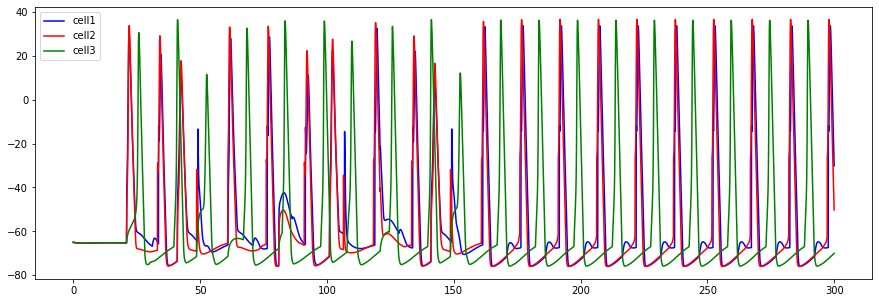

In [10]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.legend()
plt.show()

<font size='3'>__You can observe two effects here:__ one is that it takes some time for the cells to start firing regularly, and second that the cells keep firing eventhough the stimulation stops. 

## Spike detection

In [11]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time
                
                
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)

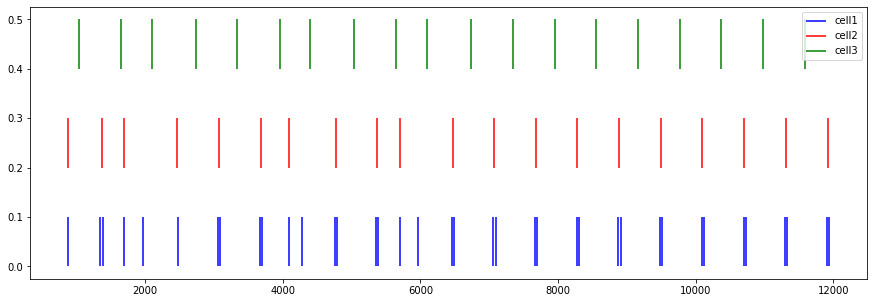

In [12]:
plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.legend()

## Step 5: Regular and asynchronous stimulation.

<font size = '3'>Add one stimulator per cell

In [13]:
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[20](0.5))
synapse1.tau = 2 # ms
stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[20](0.5))
synapse2.tau = 2 # ms
stim_cell3 = Int1
synapse3 = h.ExpSyn(stim_cell3.dend[20](0.5))
synapse3.tau = 2 # ms

stimulator1 = h.VecStim()
spike_times1 = [20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0]
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = [30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0]
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0]
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

In [14]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Int1

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)

t = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(400)

0.0

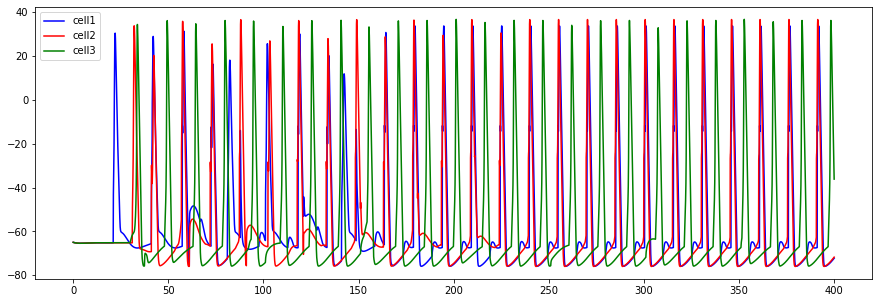

In [15]:
plt.figure(figsize=(15,5))
plt.plot(t, soma_v1, label='cell1', color='blue')
plt.plot(t, soma_v2, label='cell2', color='red')
plt.plot(t, soma_v3, label='cell3', color='green')
plt.legend()
plt.show()

<font size='3'>__You can observe two effects here:__ you can observe the same effects as before, but in this occasion it takes longer for the cells to reach to a regular firing.

# Spike detection

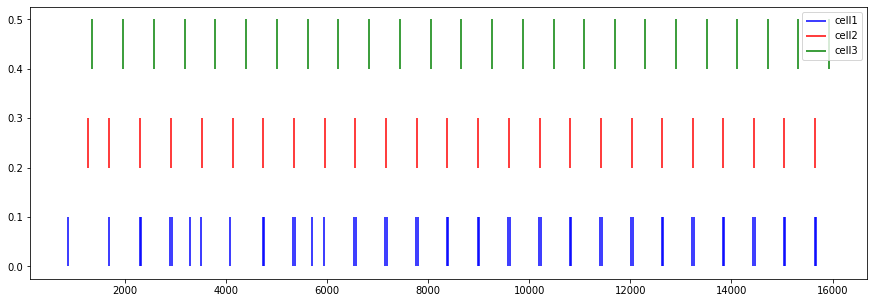

In [16]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.legend()